In [178]:
import os
import re
import yaml

In [179]:
path = r"/home/kaiser/work/repos/obsidian"

In [180]:
def walk_in_data(rootdir=path):
    for folder, _, files in os.walk(rootdir):
        print("visited", folder)
        for filename in files:
            print("visited file", filename)

In [181]:
walk_in_data()

visited /home/kaiser/work/repos/obsidian
visited file .gitattributes
visited file .gitignore
visited file Регуляризация в sklearn.md
visited file food dataset.md
visited file Градиент. Линии уровня. Почему спускаются вдоль градиента при поиске минимума?.md
visited file Pasted image 20240803192243.png
visited file Связь градиента и производной по направлению.md
visited file геометрический смысл градиента.md
visited file Какое распределение у флажка дефолта?.md
visited file Решающие деревья.md
visited file Метрические методы.md
visited file Линейные модели.md
visited file Эконометрика.md
visited file Tfidf_240721_145105.pdf
visited file Tsne_240715_140444.pdf
visited file Метрические методы_240803_200905.pdf
visited file Подстановки_240726_184159.pdf
visited file Приколы_240803_201433.pdf
visited file tfidf.md
visited file Pasted image 20240804191134.png
visited file shell.md
visited file Untitled.md
visited file distributions.md
visited file Pasted image 20240806145754.png
visited file 

In [182]:
import pandas as pd

In [183]:
df = pd.DataFrame()


def walk_in_data_and_add(rootdir=path):
    rows_list = []

    for folder, dirnames, files in os.walk(rootdir):
        for filename in files:
            if filename[-2:] != "md":
                continue
            with open(folder + "/" + filename, "r") as f:
                dict = {}
                dict.update({"directory": folder})
                dict.update({"name": ".".join(filename.split(".")[:-1])})
                dict.update({"extension": filename.split(".")[-1]})
                dict.update({"text": f.read()})

                rows_list.append(dict)
    return pd.DataFrame(rows_list)

In [184]:
df = walk_in_data_and_add()
df.to_csv("first.csv", index=False)
df

,directory,name,extension,text
0,/home/kaiser/work/repos/obsidian,Регуляризация в sklearn,md,# L2 регуляризация ([[Ridge-regression|Ridge]]...
1,/home/kaiser/work/repos/obsidian,food dataset,md,---\ntags:\n - machine_learning\n---\nhttps:/...
2,/home/kaiser/work/repos/obsidian,Градиент. Линии уровня. Почему спускаются вдол...,md,---\naliases:\n - линии уровня\n - градиент\...
3,/home/kaiser/work/repos/obsidian,Связь градиента и производной по направлению,md,---\naliases:\n - градиент\n - производная п...
4,/home/kaiser/work/repos/obsidian,геометрический смысл градиента,md,==Геометрический смысл==\nРассмотрим семейство...
...,...,...,...,...
439,/home/kaiser/work/repos/obsidian/network/templ...,daily template,md,---\ntags: daily \ndate: {{date}}\n---\n```dat...
440,/home/kaiser/work/repos/obsidian/school,Лекция 1,md,---\ntags:\n - numerical_analysis\ndate: 2024...
441,/home/kaiser/work/repos/obsidian/school,Математическое моделирование в естествознании,md,---\ntags:\n - mme\n---\nЗачет. Список литера...
442,/home/kaiser/work/repos/obsidian/school,Сиппо,md,---\ntags:\n - sippo\n---\n[СиППО 24-1 (vk.co...


In [185]:
print(df["text"].iloc[0])

# L2 регуляризация ([[Ridge-regression|Ridge]])
```python
from sklearn.linear_model import Ridge
```
# L1 регуляризация  ([[Lasso-regression|Lasso]])
```python
from sklearn.linear_model import Lasso
```
# [[ElasticNet]]



Let's detect files that contain YAML front matter.

In [186]:
df_with_yaml = df[
    df["text"].str.contains(r"(?s)^---\s*\n(.*?)\n---\s*(\n|$)", regex=True)
].reset_index(drop=True)
df_with_yaml

/tmp/ipykernel_49491/1249651775.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df["text"].str.contains(r"(?s)^---\s*\n(.*?)\n---\s*(\n|$)", regex=True)


,directory,name,extension,text
0,/home/kaiser/work/repos/obsidian,food dataset,md,---\ntags:\n - machine_learning\n---\nhttps:/...
1,/home/kaiser/work/repos/obsidian,Градиент. Линии уровня. Почему спускаются вдол...,md,---\naliases:\n - линии уровня\n - градиент\...
2,/home/kaiser/work/repos/obsidian,Связь градиента и производной по направлению,md,---\naliases:\n - градиент\n - производная п...
3,/home/kaiser/work/repos/obsidian,Решающие деревья,md,---\ntags:\n - machine_learning\naliases:\n ...
4,/home/kaiser/work/repos/obsidian,Метрические методы,md,---\ntags:\n - machine_learning\nlink: https:...
...,...,...,...,...
400,/home/kaiser/work/repos/obsidian/network/templ...,daily template,md,---\ntags: daily \ndate: {{date}}\n---\n```dat...
401,/home/kaiser/work/repos/obsidian/school,Лекция 1,md,---\ntags:\n - numerical_analysis\ndate: 2024...
402,/home/kaiser/work/repos/obsidian/school,Математическое моделирование в естествознании,md,---\ntags:\n - mme\n---\nЗачет. Список литера...
403,/home/kaiser/work/repos/obsidian/school,Сиппо,md,---\ntags:\n - sippo\n---\n[СиППО 24-1 (vk.co...


In [187]:
df_with_yaml["yaml_content"] = df_with_yaml["text"].str.extract(
    r"(?s)^---\s*\n(.*?)\n---\s*(\n|$)", expand=False
)[0]
df_with_yaml

,directory,name,extension,text,yaml_content
0,/home/kaiser/work/repos/obsidian,food dataset,md,---\ntags:\n - machine_learning\n---\nhttps:/...,tags:\n - machine_learning
1,/home/kaiser/work/repos/obsidian,Градиент. Линии уровня. Почему спускаются вдол...,md,---\naliases:\n - линии уровня\n - градиент\...,aliases:\n - линии уровня\n - градиент
2,/home/kaiser/work/repos/obsidian,Связь градиента и производной по направлению,md,---\naliases:\n - градиент\n - производная п...,aliases:\n - градиент\n - производная по нап...
3,/home/kaiser/work/repos/obsidian,Решающие деревья,md,---\ntags:\n - machine_learning\naliases:\n ...,tags:\n - machine_learning\naliases:\n - dec...
4,/home/kaiser/work/repos/obsidian,Метрические методы,md,---\ntags:\n - machine_learning\nlink: https:...,tags:\n - machine_learning\nlink: https://edu...
...,...,...,...,...,...
400,/home/kaiser/work/repos/obsidian/network/templ...,daily template,md,---\ntags: daily \ndate: {{date}}\n---\n```dat...,tags: daily \ndate: {{date}}
401,/home/kaiser/work/repos/obsidian/school,Лекция 1,md,---\ntags:\n - numerical_analysis\ndate: 2024...,tags:\n - numerical_analysis\ndate: 2024-02-12
402,/home/kaiser/work/repos/obsidian/school,Математическое моделирование в естествознании,md,---\ntags:\n - mme\n---\nЗачет. Список литера...,tags:\n - mme
403,/home/kaiser/work/repos/obsidian/school,Сиппо,md,---\ntags:\n - sippo\n---\n[СиППО 24-1 (vk.co...,tags:\n - sippo


Looks that dict column will be painful to use for ML algorithms. It is essential to extract features using `DictVectorizer`

In [188]:
def erase_yaml(row):
    len_of_yaml = 1 + len(row["yaml_content"]) + 8  # --- symbols + \n
    row["text"] = row["text"][len_of_yaml:]
    return row


df_with_yaml = df_with_yaml.apply(erase_yaml, axis="columns")
df_with_yaml

,directory,name,extension,text,yaml_content
0,/home/kaiser/work/repos/obsidian,food dataset,md,https://huggingface.co/datasets/HC-85/open-foo...,tags:\n - machine_learning
1,/home/kaiser/work/repos/obsidian,Градиент. Линии уровня. Почему спускаются вдол...,md,Линии уровня (contour lines) - множества точек...,aliases:\n - линии уровня\n - градиент
2,/home/kaiser/work/repos/obsidian,Связь градиента и производной по направлению,md,### Определение\n\nНаправленная производная фу...,aliases:\n - градиент\n - производная по нап...
3,/home/kaiser/work/repos/obsidian,Решающие деревья,md,[[Решающее дерево и композиции алгоритмов]]\nп...,tags:\n - machine_learning\naliases:\n - dec...
4,/home/kaiser/work/repos/obsidian,Метрические методы,md,![[Метрические методы_240803_200905.pdf]],tags:\n - machine_learning\nlink: https://edu...
...,...,...,...,...,...
400,/home/kaiser/work/repos/obsidian/network/templ...,daily template,md,"```dataview\ntable without id\nfile.link as ""И...",tags: daily \ndate: {{date}}
401,/home/kaiser/work/repos/obsidian/school,Лекция 1,md,Вычислительные методы - раздел функционального...,tags:\n - numerical_analysis\ndate: 2024-02-12
402,/home/kaiser/work/repos/obsidian/school,Математическое моделирование в естествознании,md,Зачет. Список литературы\n1) «Неустойчивости и...,tags:\n - mme
403,/home/kaiser/work/repos/obsidian/school,Сиппо,md,[СиППО 24-1 (vk.com)](https://vk.com/club22460...,tags:\n - sippo


In [189]:
import yaml._yaml


def preprocess_yaml(row):
    try:
        row = yaml.safe_load(row) if pd.notnull(row) else None
    except yaml.constructor.ConstructorError:
        return "{}"
    
    if row == None:
        return row
    for key in row.keys():
        if isinstance(row[key], list) and len(row[key]) == 1:
            row[key] = row[key][0]
    return row


df_with_yaml["yaml_content"] = df_with_yaml["yaml_content"].apply(preprocess_yaml)
df_with_yaml["yaml_content"]

0                           {'tags': 'machine_learning'}
1              {'aliases': ['линии уровня', 'градиент']}
2      {'aliases': ['градиент', 'производная по напра...
3      {'tags': 'machine_learning', 'aliases': 'decis...
4      {'tags': 'machine_learning', 'link': 'https://...
                             ...                        
400                                                   {}
401    {'tags': 'numerical_analysis', 'date': 2024-02...
402                                      {'tags': 'mme'}
403                                    {'tags': 'sippo'}
404                       {'tags': 'numerical_analysis'}
Name: yaml_content, Length: 405, dtype: object

In [190]:
df_with_yaml

,directory,name,extension,text,yaml_content
0,/home/kaiser/work/repos/obsidian,food dataset,md,https://huggingface.co/datasets/HC-85/open-foo...,{'tags': 'machine_learning'}
1,/home/kaiser/work/repos/obsidian,Градиент. Линии уровня. Почему спускаются вдол...,md,Линии уровня (contour lines) - множества точек...,"{'aliases': ['линии уровня', 'градиент']}"
2,/home/kaiser/work/repos/obsidian,Связь градиента и производной по направлению,md,### Определение\n\nНаправленная производная фу...,"{'aliases': ['градиент', 'производная по напра..."
3,/home/kaiser/work/repos/obsidian,Решающие деревья,md,[[Решающее дерево и композиции алгоритмов]]\nп...,"{'tags': 'machine_learning', 'aliases': 'decis..."
4,/home/kaiser/work/repos/obsidian,Метрические методы,md,![[Метрические методы_240803_200905.pdf]],"{'tags': 'machine_learning', 'link': 'https://..."
...,...,...,...,...,...
400,/home/kaiser/work/repos/obsidian/network/templ...,daily template,md,"```dataview\ntable without id\nfile.link as ""И...",{}
401,/home/kaiser/work/repos/obsidian/school,Лекция 1,md,Вычислительные методы - раздел функционального...,"{'tags': 'numerical_analysis', 'date': 2024-02..."
402,/home/kaiser/work/repos/obsidian/school,Математическое моделирование в естествознании,md,Зачет. Список литературы\n1) «Неустойчивости и...,{'tags': 'mme'}
403,/home/kaiser/work/repos/obsidian/school,Сиппо,md,[СиППО 24-1 (vk.com)](https://vk.com/club22460...,{'tags': 'sippo'}


# TF-IDF

In [191]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt


def get_word_cloud(text, ngram_range=(1, 1)):
    vec = TfidfVectorizer(ngram_range=ngram_range)
    X = vec.fit_transform(text)
    words_tfidf = dict(zip(vec.get_feature_names_out(), X.sum(axis=0).A1)) # np.asarray(X.sum(axis=0)).ravel()
    wordCloud = WordCloud(
        width=2000, height=2000, random_state=42, background_color="white"
    ).generate_from_frequencies(words_tfidf)

    plt.figure(figsize=(15, 15))
    plt.axis("off")
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.show()

## A bit of visualization

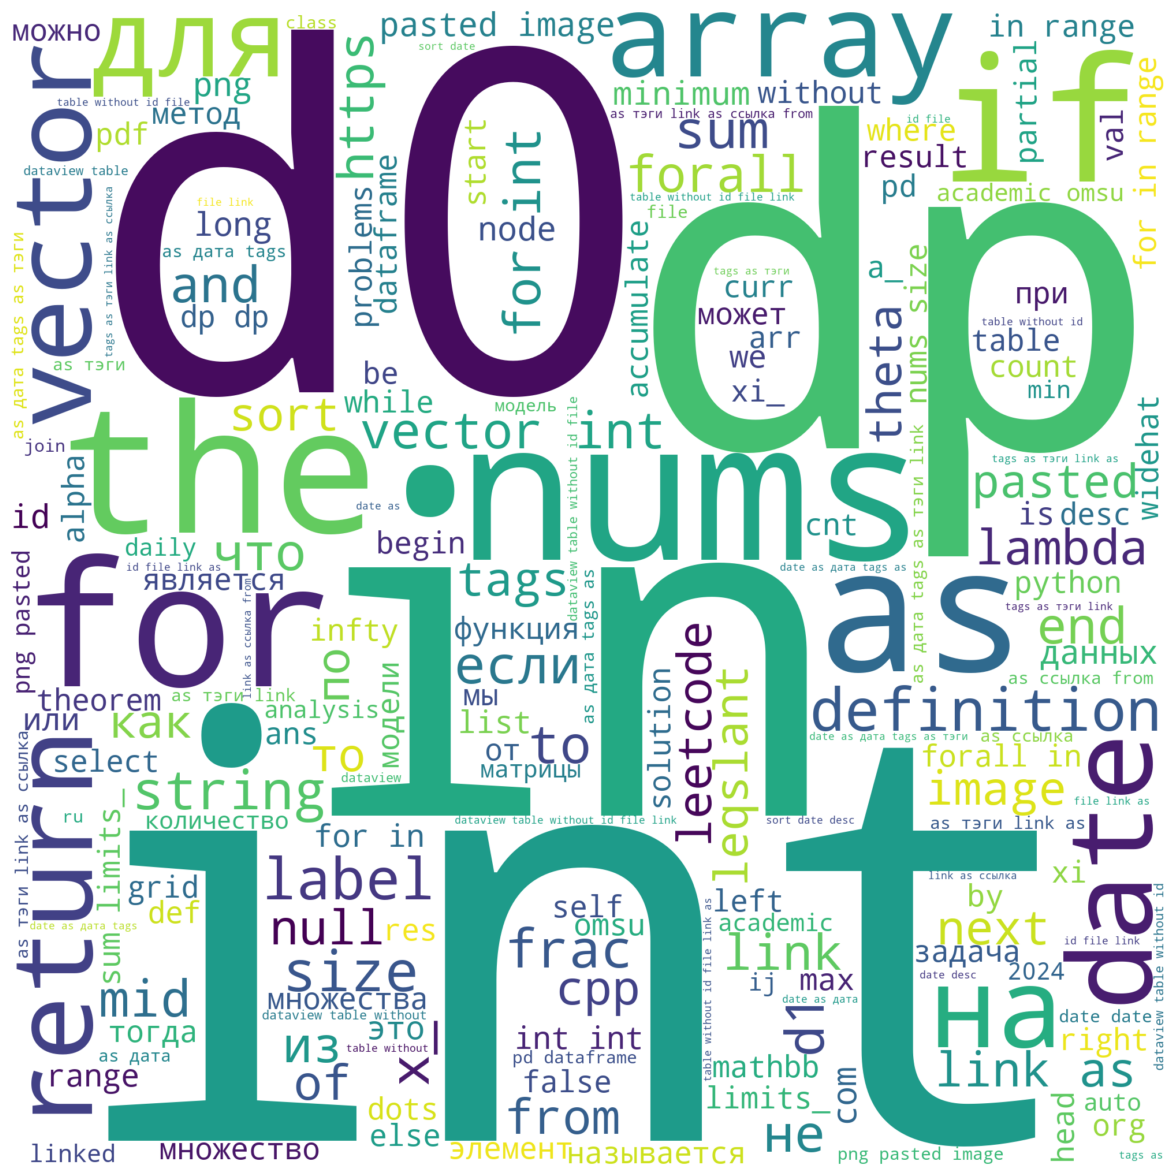

In [192]:
get_word_cloud(df_with_yaml['text'], (1, 6))

In [193]:
normalized_yaml_content = pd.json_normalize(df_with_yaml["yaml_content"]).fillna("")
normalized_yaml_content

,tags,aliases,link,cssclasses,sr-due,sr-interval,sr-ease,date,excalidraw-plugin,complexity
0,machine_learning,,,,,,,,,
1,,"[линии уровня, градиент]",,,,,,,,
2,,"[градиент, производная по направлению]",,,,,,,,
3,machine_learning,decision tree,https://education.yandex.ru/handbook/ml/articl...,,,,,,,
4,machine_learning,,https://education.yandex.ru/handbook/ml/articl...,,,,,,,
...,...,...,...,...,...,...,...,...,...,...
400,,,,,,,,,,
401,numerical_analysis,,,,,,,2024-02-12,,
402,mme,,,,,,,,,
403,sippo,,,,,,,,,


In [194]:
normalized_yaml_content.drop(columns=["sr-due", "sr-interval", "sr-ease", "excalidraw-plugin"], inplace=True)

In [195]:
pd.concat([df_with_yaml, normalized_yaml_content], axis=1)

,directory,name,extension,text,yaml_content,tags,aliases,link,cssclasses,date,complexity
0,/home/kaiser/work/repos/obsidian,food dataset,md,https://huggingface.co/datasets/HC-85/open-foo...,{'tags': 'machine_learning'},machine_learning,,,,,
1,/home/kaiser/work/repos/obsidian,Градиент. Линии уровня. Почему спускаются вдол...,md,Линии уровня (contour lines) - множества точек...,"{'aliases': ['линии уровня', 'градиент']}",,"[линии уровня, градиент]",,,,
2,/home/kaiser/work/repos/obsidian,Связь градиента и производной по направлению,md,### Определение\n\nНаправленная производная фу...,"{'aliases': ['градиент', 'производная по напра...",,"[градиент, производная по направлению]",,,,
3,/home/kaiser/work/repos/obsidian,Решающие деревья,md,[[Решающее дерево и композиции алгоритмов]]\nп...,"{'tags': 'machine_learning', 'aliases': 'decis...",machine_learning,decision tree,https://education.yandex.ru/handbook/ml/articl...,,,
4,/home/kaiser/work/repos/obsidian,Метрические методы,md,![[Метрические методы_240803_200905.pdf]],"{'tags': 'machine_learning', 'link': 'https://...",machine_learning,,https://education.yandex.ru/handbook/ml/articl...,,,
...,...,...,...,...,...,...,...,...,...,...,...
400,/home/kaiser/work/repos/obsidian/network/templ...,daily template,md,"```dataview\ntable without id\nfile.link as ""И...",{},,,,,,
401,/home/kaiser/work/repos/obsidian/school,Лекция 1,md,Вычислительные методы - раздел функционального...,"{'tags': 'numerical_analysis', 'date': 2024-02...",numerical_analysis,,,,2024-02-12,
402,/home/kaiser/work/repos/obsidian/school,Математическое моделирование в естествознании,md,Зачет. Список литературы\n1) «Неустойчивости и...,{'tags': 'mme'},mme,,,,,
403,/home/kaiser/work/repos/obsidian/school,Сиппо,md,[СиППО 24-1 (vk.com)](https://vk.com/club22460...,{'tags': 'sippo'},sippo,,,,,


Http as column?

In [196]:
from sklearn.compose import ColumnTransformer

In [197]:
from sklearn.cluster import DBSCAN, Birch

dbscan = DBSCAN()

# dbscan.fit()